In [75]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
import os

import numpy as np
import torch

from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, RandomAffine, RandomHorizontalFlip

In [77]:
from src.data.datasets_class import SplitAndAugmentDataset
from src.data.datasets import get_dual_cifar10
DATASET_NAME = 'dual_cifar10'
dataset_path=os.environ['CIFAR10_PATH']
transform1 = Compose([ToTensor()])
transform2 = Compose([ToTensor()])

In [78]:
train_dataset = datasets.CIFAR10(dataset_path, train=True, download=True)
train_dual_augment_dataset= SplitAndAugmentDataset(train_dataset, transform1, transform2, overlap=0.0, is_train=False)

Files already downloaded and verified
overlap: 0.0 with_overlap: 0.5


In [5]:
len(train_dual_augment_dataset.dataset.targets)

50000

In [79]:
def get_held_out_data(dataset, nb_samples=1000):
    y_data = np.array(dataset.dataset.targets)
    num_classes = len(np.unique(y_data))
    nb_samples_per_class = nb_samples // num_classes
    idxs = []
    for i in range(num_classes):
        idxs_i = np.where(y_data == i)[0]
        sampled_idxs_i = np.random.choice(idxs_i, size=nb_samples_per_class, replace=False)
        idxs.append(sampled_idxs_i)
        
    idxs = np.concatenate(idxs)
    selected_elements = [dataset[i] for i in idxs]
    x_data, y_data = zip(*selected_elements)
    x_data_left, x_data_right = zip(*x_data)
    
    x_data_left = torch.stack(x_data_left)
    x_data_right = torch.stack(x_data_right)
    y_data = torch.tensor(y_data)
    # x_data_fellow = np.array(x_data_fellow)
    # x_data_amblyopic = np.array(x_data_amblyopic)
    
    if not os.path.exists('data'):
        os.mkdir('data')
        
    description = 'rsv'
        
    return x_data_left, x_data_right
    # np.save(f'data/{dataset_name}_held_out_x.npy', x_data)
    # np.save(f'data/{dataset_name}_held_out_y.npy', y_data)
    # return x_data_fellow, x_data_amblyopic, y_data

In [164]:
x_data_left, x_data_right = get_held_out_data(train_dual_augment_dataset, nb_samples=50)

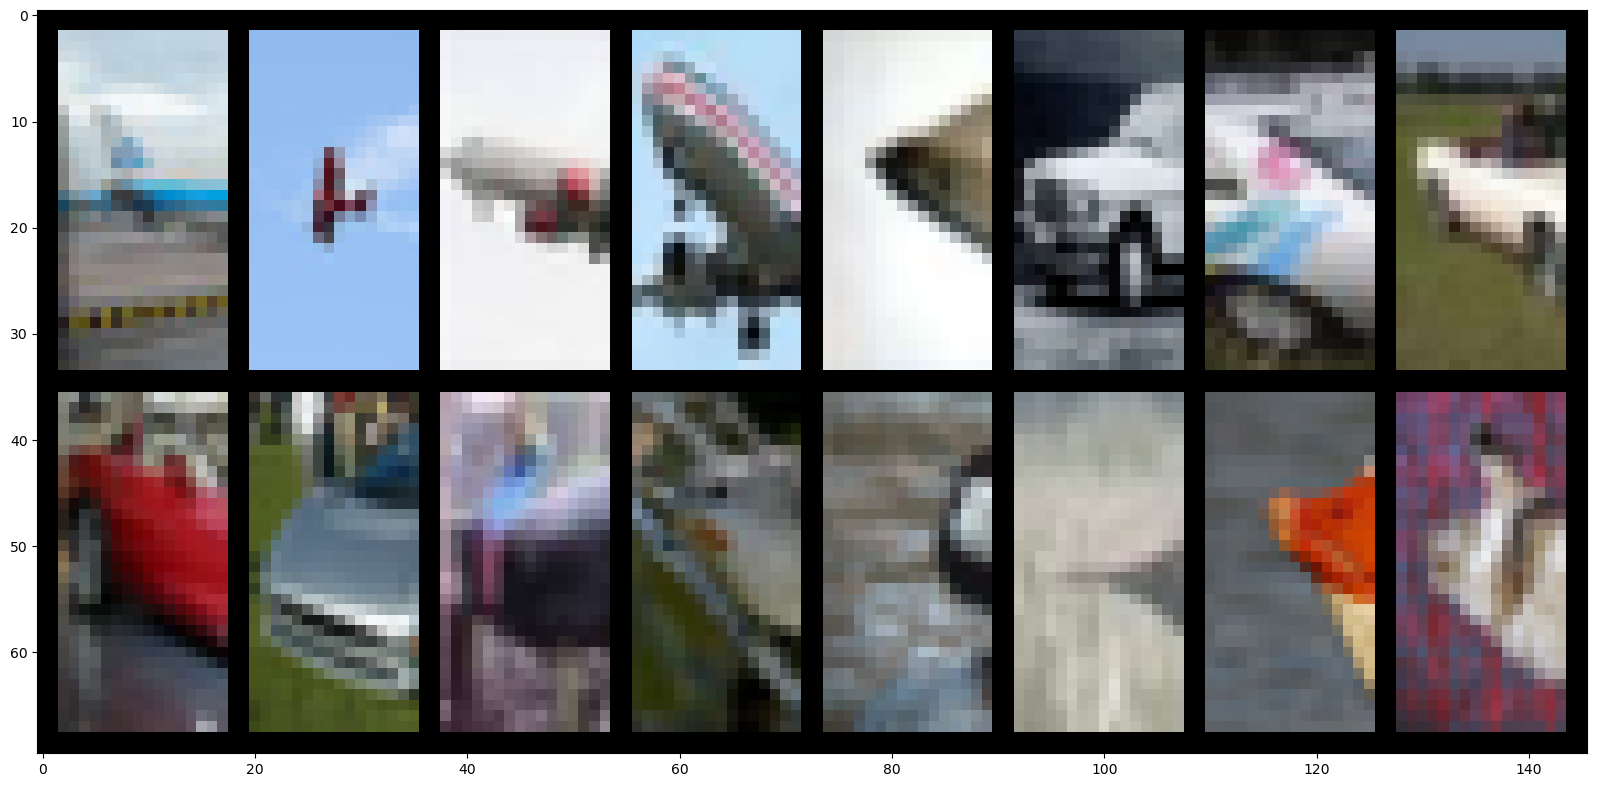

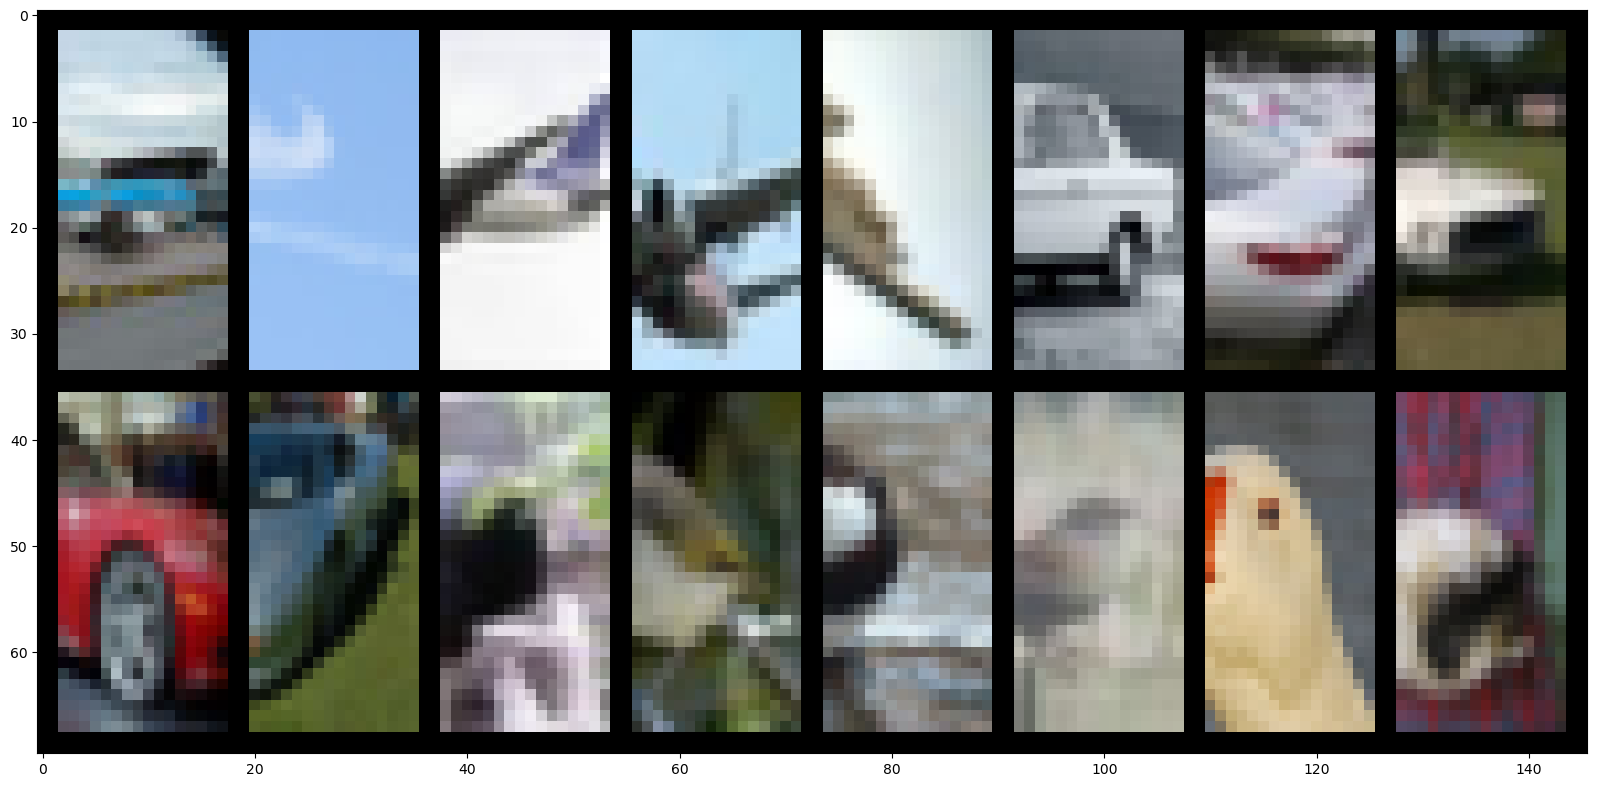

In [165]:
import torchvision
import numpy as np

import matplotlib.pyplot as plt
def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

grid = torchvision.utils.make_grid(x_data_left[:16])
show(grid)
grid = torchvision.utils.make_grid(x_data_right[:16])
show(grid)

In [166]:
from torchvision.transforms import InterpolationMode
from src.data.transforms import SIDE_MAP_PROPER

color_jitter_transform = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
rotation_transform = transforms.RandomRotation(degrees=10, interpolation=InterpolationMode.BILINEAR)
random_affine = RandomAffine(degrees=0, translate=(1/8, 1/8))
random_erasing_transform = transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=True)


DATASET_NAME = 'dual_cifar10'
transform_aug = lambda side: transforms.Compose([
    color_jitter_transform,
    rotation_transform,
    random_affine,
    Normalize(*SIDE_MAP_PROPER[side][0.0]),
    random_erasing_transform
])

transform_aug2 = transforms.TrivialAugmentWide(interpolation=InterpolationMode.BILINEAR)


In [104]:
# x_data_left = torch.clip(x_data_left * 255.0, 0.0, 255.0).type(torch.uint8)

# x_data_right = torch.clip(x_data_right * 255.0, 0.0, 255.0).type(torch.uint8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


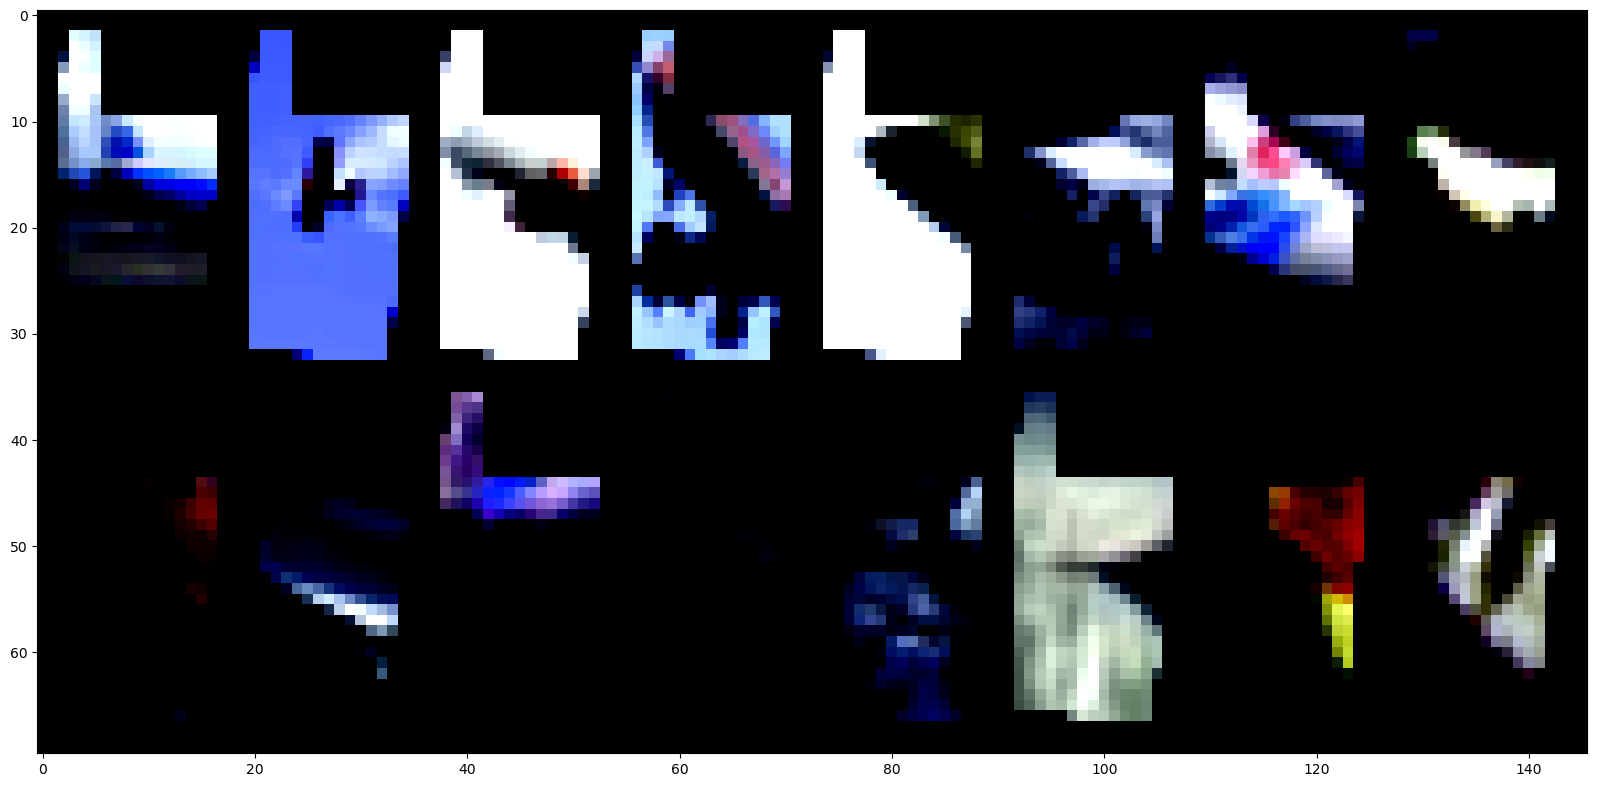

In [167]:
grid = torchvision.utils.make_grid(transform_aug('left')(x_data_left[:16]))
show(grid)

In [168]:
left, right = [], []
for i in range(x_data_left.shape[0]):
    left.append(x_data_left[i])
    right.append(x_data_right[i])
    for j in range(99):
        left.append(transform_aug('left')(x_data_left[i]))
        right.append(transform_aug('right')(x_data_right[i]))

left = torch.stack(left)
right = torch.stack(right)

torch.save(left, f'data/{DATASET_NAME}_held_out_rsv_x_left.pt')
torch.save(right, f'data/{DATASET_NAME}_held_out_rsv_x_right.pt')

In [128]:
left = torch.load(f'data/{DATASET_NAME}_held_out_rsv_x_left.pt')
right = torch.load(f'data/{DATASET_NAME}_held_out_rsv_x_right.pt')

In [169]:
num_groups = 50
# Liczba elementów w każdej grupie
group_size = len(left) // num_groups

# Tworzymy listy wynikowe
result_left = []
result_right = []

for i in range(num_groups):
    # Pobieranie pierwszego tensora z grupy z x_left
    first_tensor1 = left[i * group_size]
    first_tensor2 = right[i * group_size]
    # Dodawanie pierwszego tensora trzy razy do result_left
    result_left.extend([first_tensor1] * group_size)
    result_right.extend(list(reversed(right[i * group_size: (i+1) * group_size])))
    result_right.extend([first_tensor2] * (group_size-1))
    result_left.extend(left[i * group_size + 1: (i+1) * group_size])
# print(result_left)
# print(result_right)

In [170]:
len(result_left)

9950

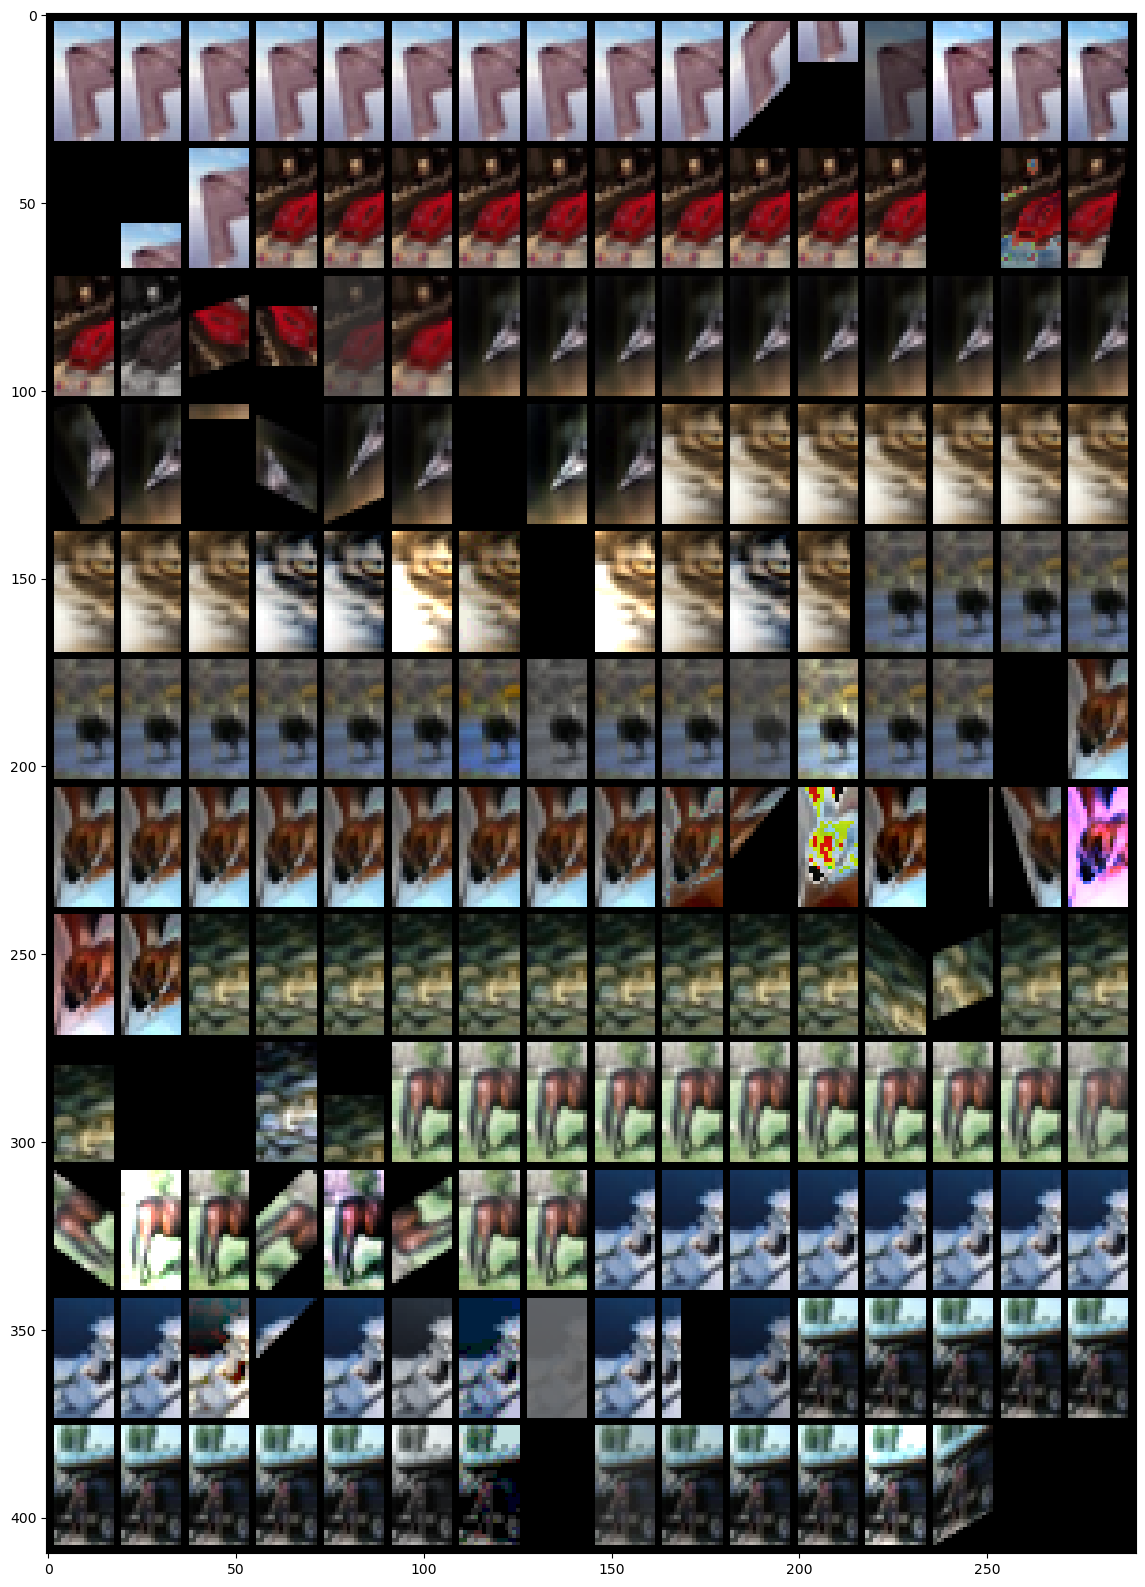

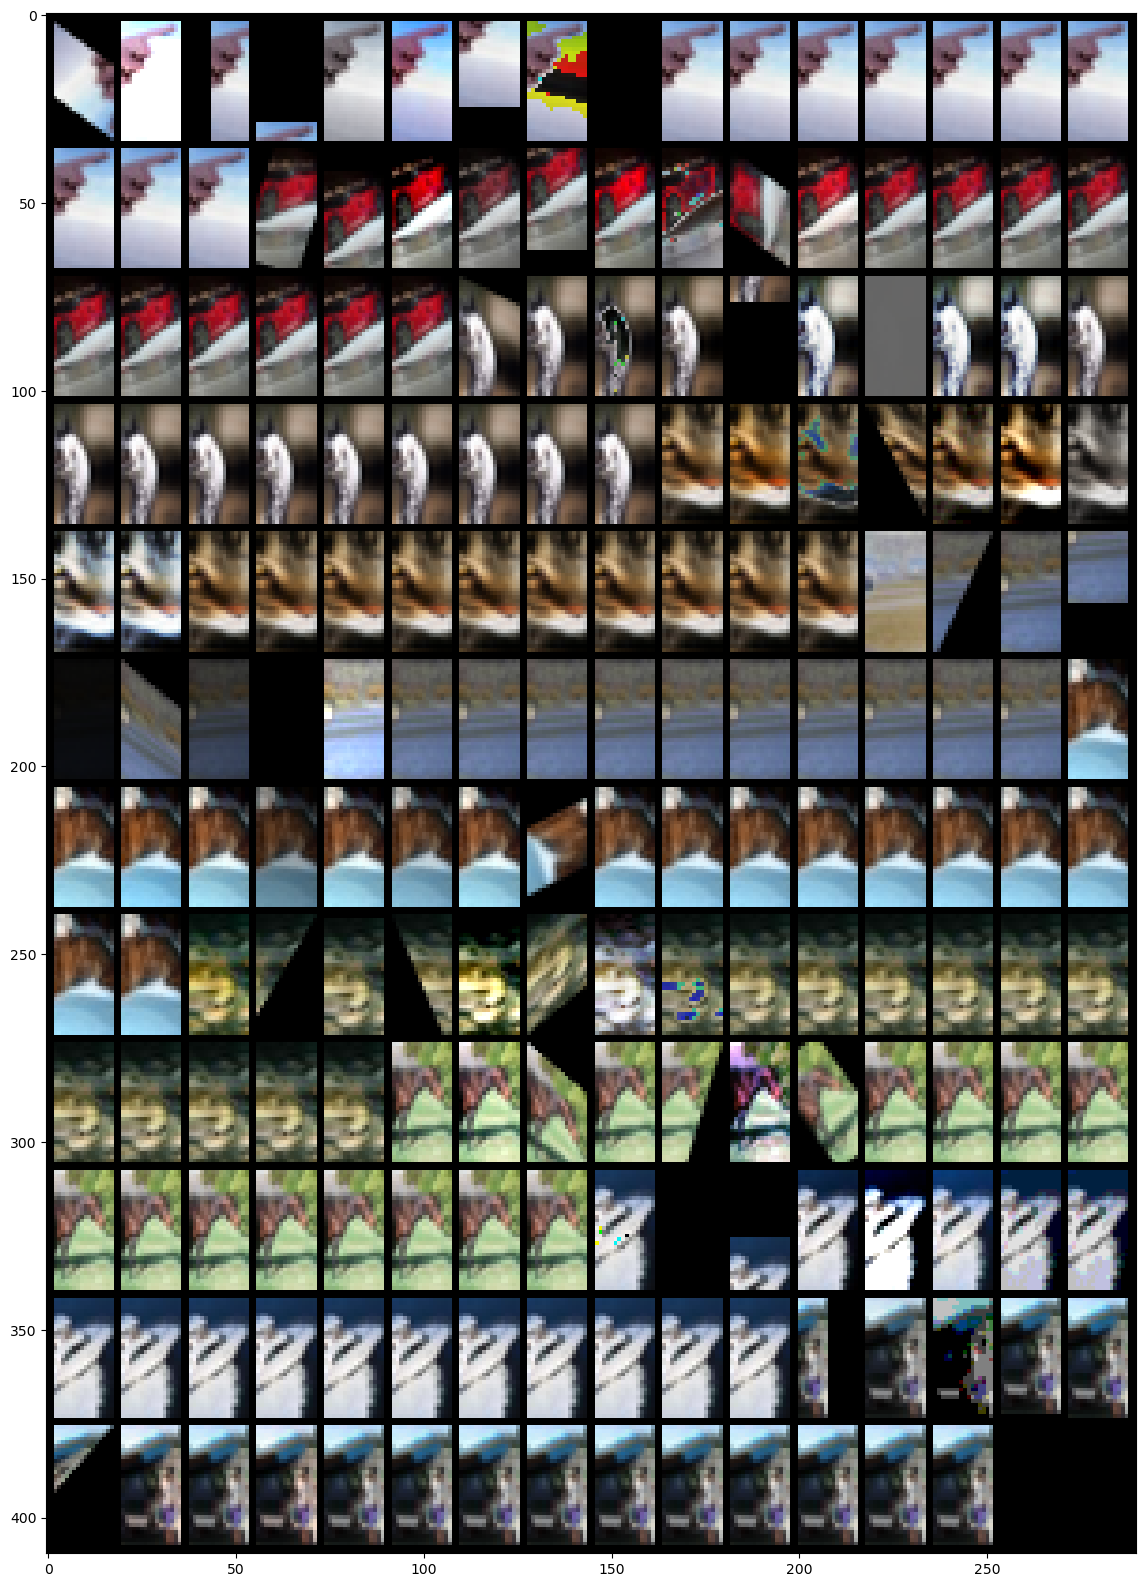

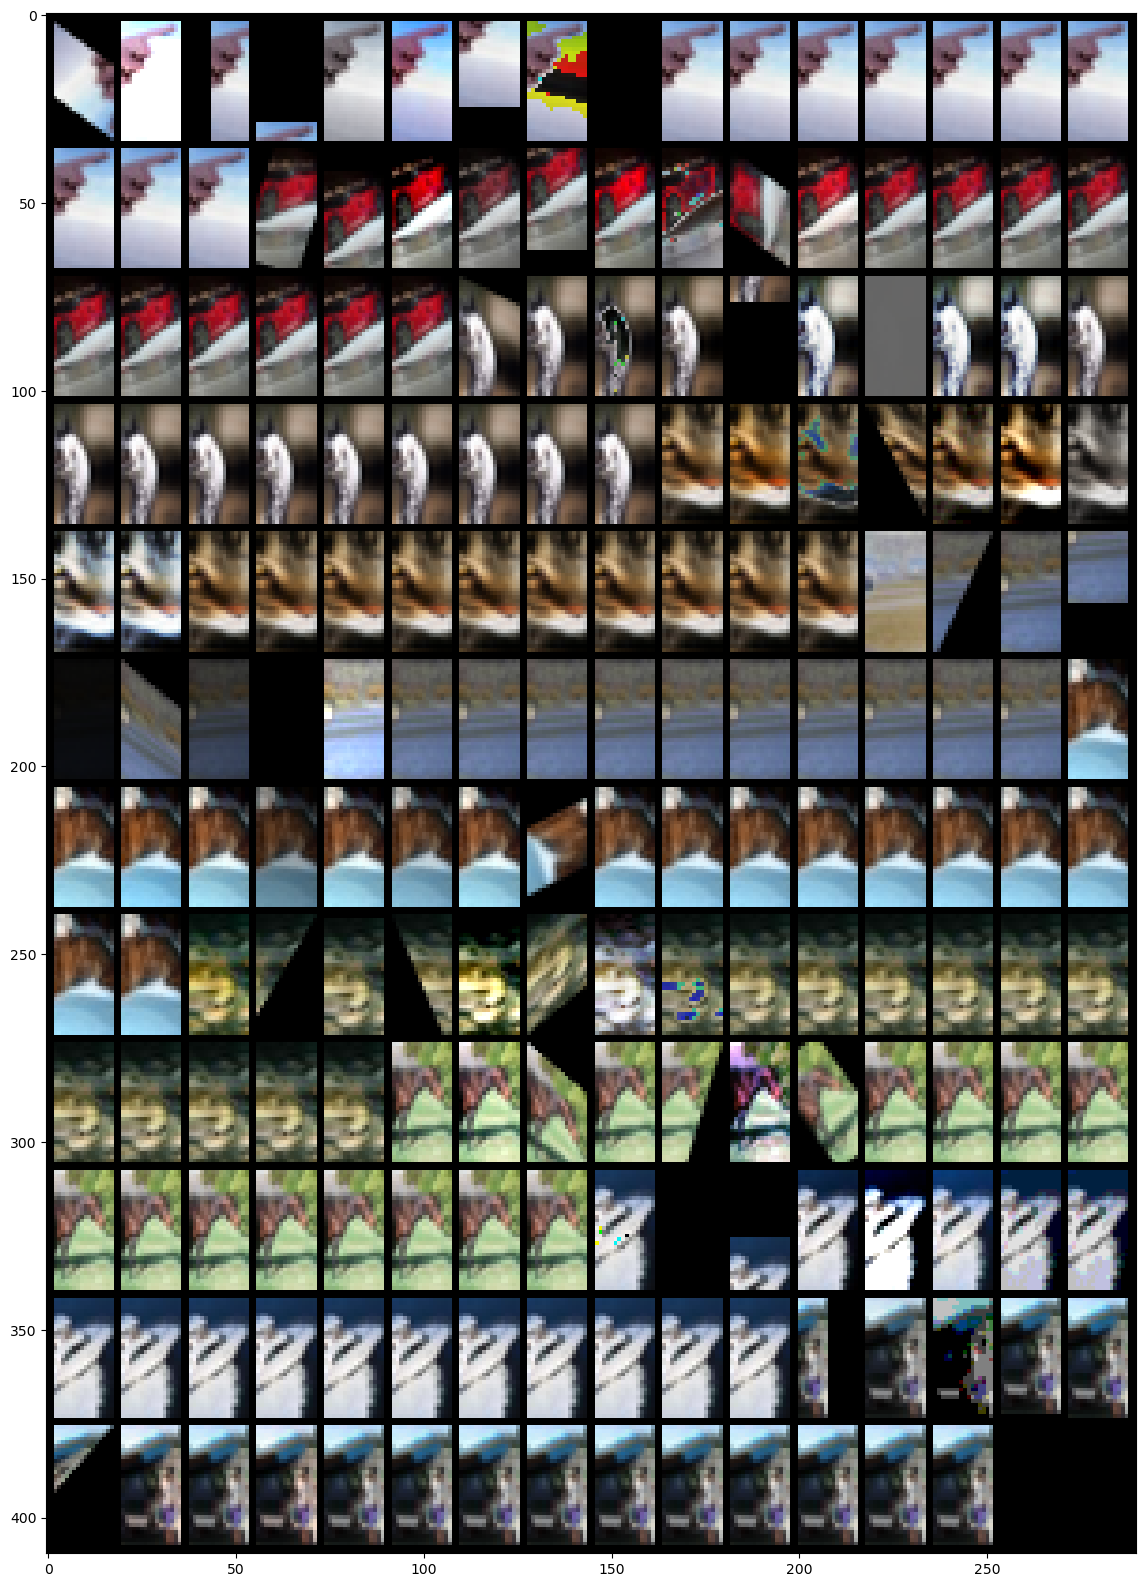

In [89]:
grid = torchvision.utils.make_grid(result_left, nrow=16)
show(grid)
grid = torchvision.utils.make_grid(result_right, nrow=16)
show(grid)
show(grid)

In [171]:
x_data_left = torch.stack(result_left)
x_data_right = torch.stack(result_right)

# Model

In [172]:
from src.utils.utils_trainer import load_model
from src.utils.prepare import prepare_model
from src.modules.hooks import Hooks

In [173]:
model_config = {'backbone_type': 'resnet18',
                'only_features': False,
                'batchnorm_layers': True,
                'width_scale': 1.0,
                'skips': True,
                'modify_resnet': True,
                'wheter_concate': False,
                'overlap': 0.0,}
model_params = {'model_config': model_config, 'num_classes': 10, 'dataset_name': 'dual_cifar10'}

model = prepare_model('mm_resnet', model_params=model_params)

In [279]:
# model = load_model(model, '/raid/NFS_SHARE/home/b.krzepkowski/Github/CLPInterventions/reports/just_run, sgd, dual_cifar10, mm_resnet_fp_0.0_lr_0.55_wd_0.0 overlap=0.0, phase2, trained with phase1=0/2023-09-06_21-48-17/checkpoints/model_step_epoch_200.pth')
# model = load_model(model, '/raid/NFS_SHARE/home/b.krzepkowski/Github/CLPInterventions/reports/just_run, sgd, dual_cifar10, mm_resnet_fp_0.0_lr_0.55_wd_0.0 overlap=0.0, phase2, trained with phase1=80/2023-09-07_00-08-43/checkpoints/model_step_epoch_200.pth')
# model = load_model(model, '/raid/NFS_SHARE/home/b.krzepkowski/Github/CLPInterventions/reports/just_run, sgd, dual_cifar10, mm_resnet_fp_0.0_lr_0.6_wd_0.0 overlap=0.0, phase4, trained with phase1=80 and phase2=0 and phase3=0/2023-09-07_19-44-48/checkpoints/model_step_epoch_200.pth')
model = load_model(model, '/raid/NFS_SHARE/home/b.krzepkowski/Github/CLPInterventions/reports/deficit_reverse, sgd, dual_cifar10, mm_resnet_fp_0.0_lr_0.55_wd_0.0_lr_lambda_1.0 overlap=0.0, phase1/2023-09-09_16-42-50/checkpoints/model_step_epoch_200.pth')
# model = load_model(model, '/raid/NFS_SHARE/home/b.krzepkowski/Github/CLPInterventions/reports/just_run, sgd, dual_cifar10, mm_resnet_fp_0.0_lr_0.6_wd_0.0 overlap=0.0, phase4, trained with phase1=80 and phase2=0 and phase3=200/2023-09-07_22-07-08/checkpoints/model_step_epoch_200.pth')

device cpu


In [280]:
hooks_rsv = Hooks(model.net3, logger=None, callback_type='rsv')
hooks_rsv.register_hooks(model.net3, [torch.nn.Conv2d, torch.nn.Linear])
hooks_rsv.enable()
hooks_rsv.callback.group_size = len(result_left) // 50


In [281]:
_ = model(x_data_left, x_data_right,
          left_branch_intervention=None,
          right_branch_intervention=None,
          enable_left_branch=True,
          enable_right_branch=True)

In [282]:
data = hooks_rsv.gather_data()
hooks_rsv.reset()
len(data)

10

<AxesSubplot:ylabel='Count'>

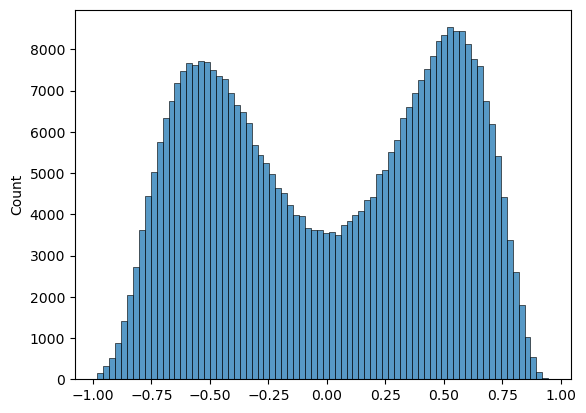

In [283]:
# deficit=0
import seaborn as sns
data1 = torch.stack(data[9]).reshape(-1).detach().cpu().numpy()
data1.shape
# data1 = torch.stack(data[0])
sns.histplot(data=data1)

<AxesSubplot:ylabel='Count'>

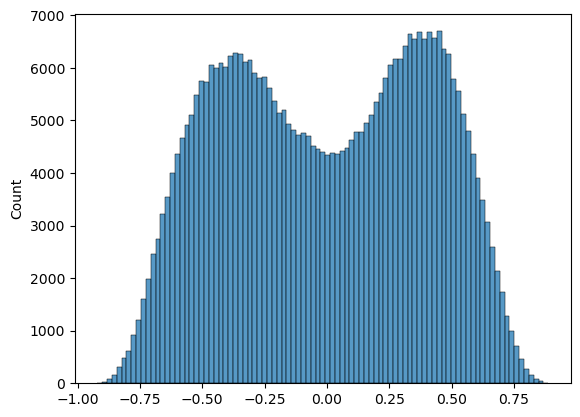

In [278]:
# deficit=0
import seaborn as sns
data1 = torch.stack(data[9]).reshape(-1).detach().cpu().numpy()
data1.shape
# data1 = torch.stack(data[0])
sns.histplot(data=data1)

<AxesSubplot:ylabel='Count'>

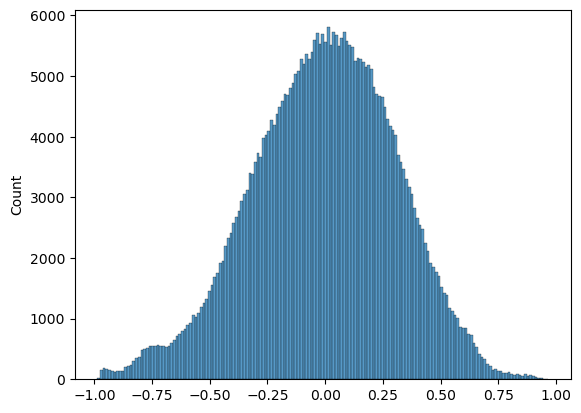

In [273]:
# phase3=0
import seaborn as sns
data1 = torch.stack(data[9]).reshape(-1).detach().cpu().numpy()
data1.shape
# data1 = torch.stack(data[0])
sns.histplot(data=data1)

<AxesSubplot:ylabel='Count'>

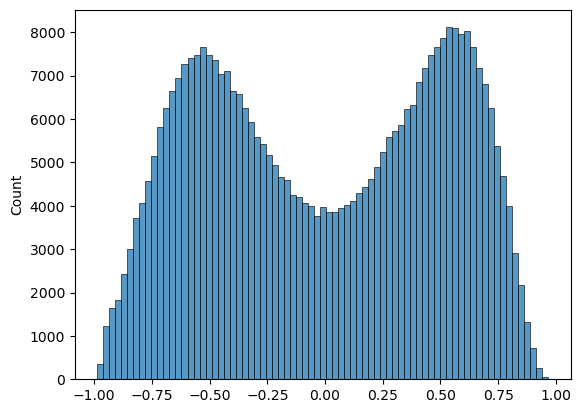

In [229]:
# phase3=0
import seaborn as sns
data1 = torch.stack(data[9]).reshape(-1).detach().cpu().numpy()
data1.shape
# data1 = torch.stack(data[0])
sns.histplot(data=data1)

<AxesSubplot:ylabel='Count'>

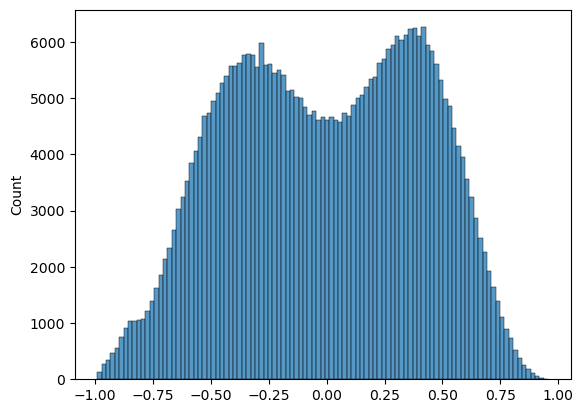

In [250]:
# phase3=20
import seaborn as sns
data1 = torch.stack(data[9]).reshape(-1).detach().cpu().numpy()
data1.shape
# data1 = torch.stack(data[0])
sns.histplot(data=data1)

<AxesSubplot:ylabel='Count'>

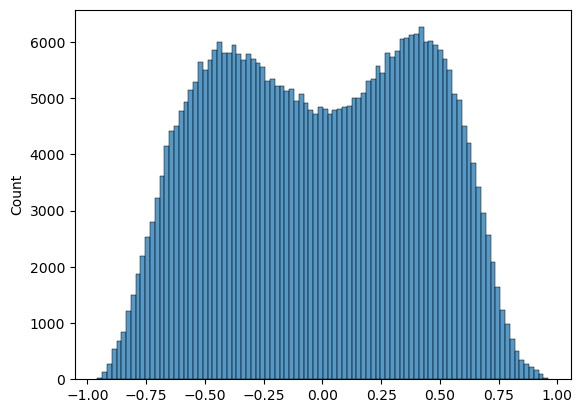

In [255]:
# phase3=40
import seaborn as sns
data1 = torch.stack(data[9]).reshape(-1).detach().cpu().numpy()
data1.shape
# data1 = torch.stack(data[0])
sns.histplot(data=data1)

<AxesSubplot:ylabel='Count'>

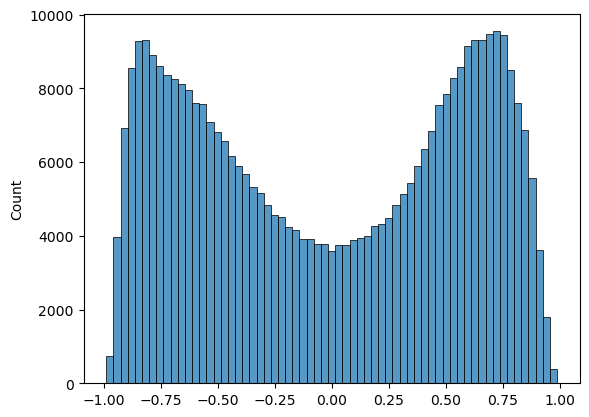

In [261]:
# phase3=160
import seaborn as sns
data1 = torch.stack(data[9]).reshape(-1).detach().cpu().numpy()
data1.shape
# data1 = torch.stack(data[0])
sns.histplot(data=data1)

<AxesSubplot:ylabel='Count'>

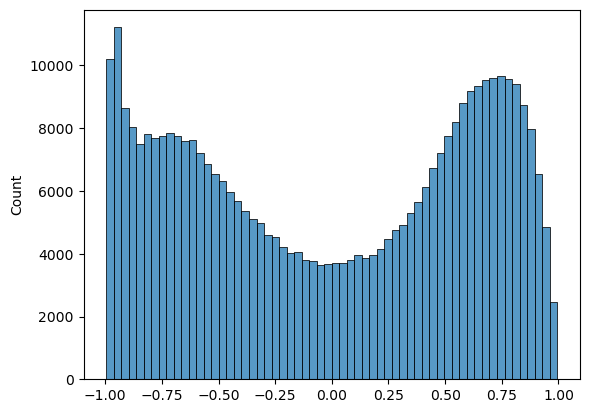

In [268]:
# phase3=200
import seaborn as sns
data1 = torch.stack(data[9]).reshape(-1).detach().cpu().numpy()
data1.shape
# data1 = torch.stack(data[0])
sns.histplot(data=data1)

<AxesSubplot:ylabel='Count'>

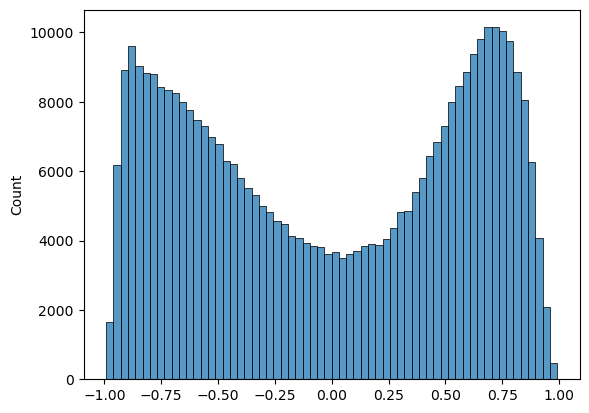

In [219]:
# phase3=200
import seaborn as sns
data1 = torch.stack(data[9]).reshape(-1).detach().cpu().numpy()
data1.shape
# data1 = torch.stack(data[0])
sns.histplot(data=data1)

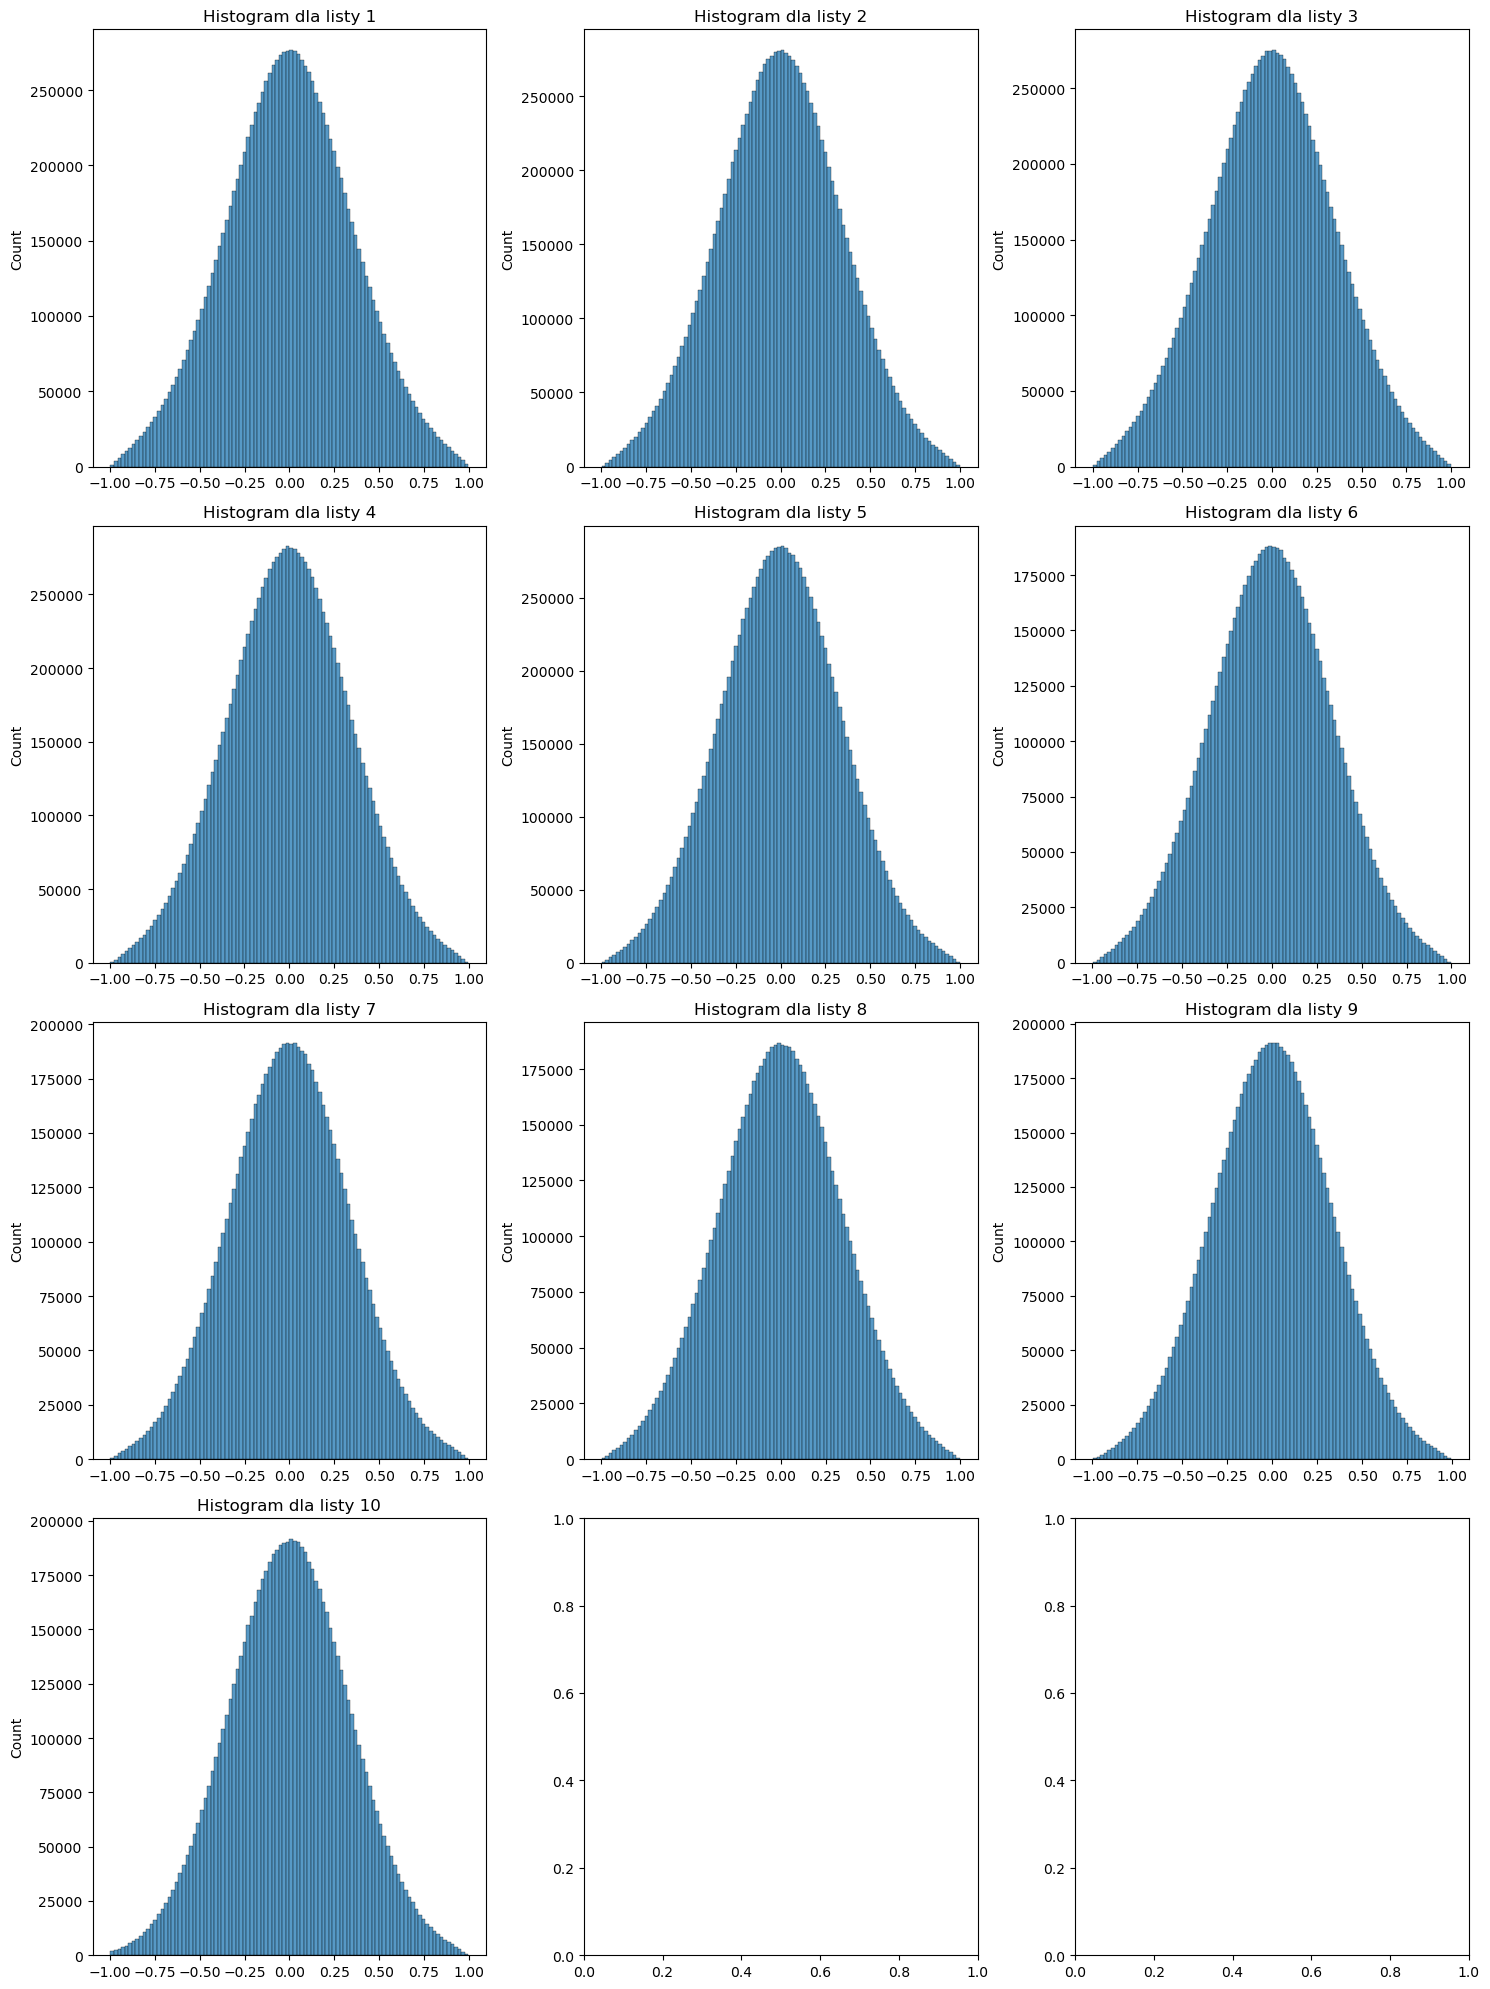

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt


# Ustawienie siatki wykresów
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))

for i in range(10):
    row = i // 3
    col = i % 3
    values = torch.stack(data[i]).reshape(-1).detach().cpu().numpy()
    sns.histplot(values, bins=100, ax=axes[row, col])
    axes[row, col].set_title(f'Histogram dla listy {i + 1}')

plt.tight_layout()
plt.show()
